## Méthode : Particle Filter (PF)

Ce notebook présente l'utilisation du fichier `pf.py` pour assimiler des données


In [1]:
import sys
sys.path.insert(0, '..\SOURCE')

from PfWoFost import PfWoFoSt
import numpy as np
import datetime as dt
import pandas as pd

from dataloader import Dataloader

from pcse.base import ParameterProvider
from utils import *
import matplotlib.pyplot as plt

# Pour eviter les warnings intempestifs
import warnings
warnings.filterwarnings('ignore')

# 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.
Dans cet exemple, on va essayer de simuler le champ de notre client

In [2]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [3]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.210785,22.854223
2022-10-03,1.989233,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.233511,23.990529
2022-10-04,1.993524,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.231742,23.902066
2022-10-05,1.998490,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.230323,23.831142
2022-10-06,2.000000,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.229986,23.814270


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client

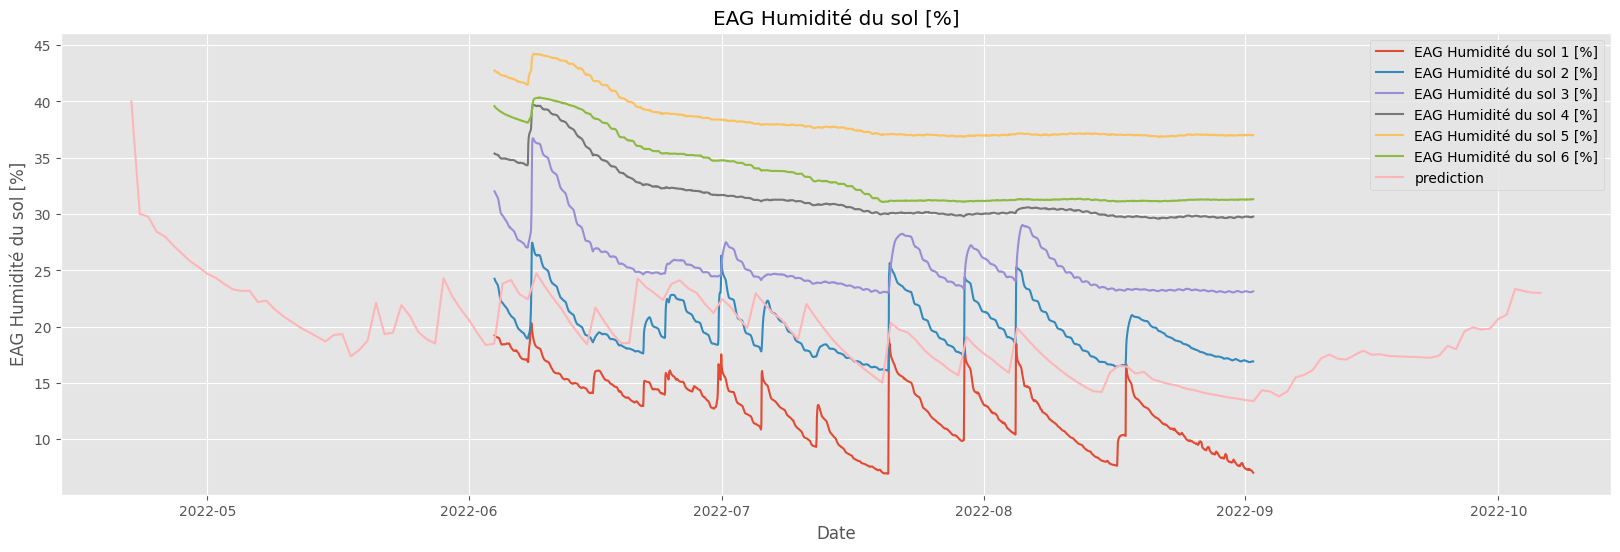

In [4]:


df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

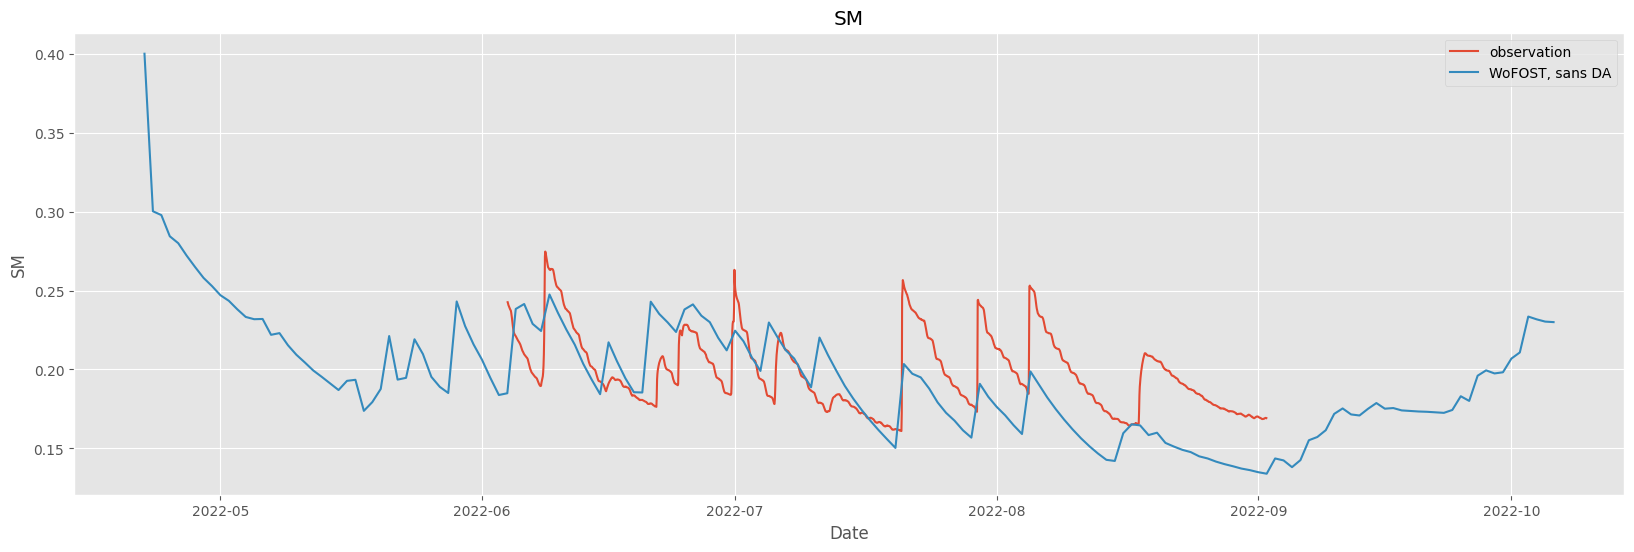

In [5]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

range1=(150.,50.)
range2=(4.5,1.5)
range3=(31,3)
range4=(0.31,0.03)

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition

<AxesSubplot: title={'center': 'SM'}, xlabel='day'>

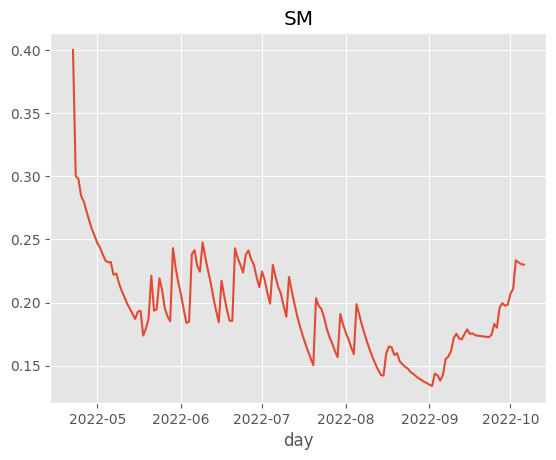

In [6]:
df_wofost_noDA['SM'].plot(y='DVS', title='SM')

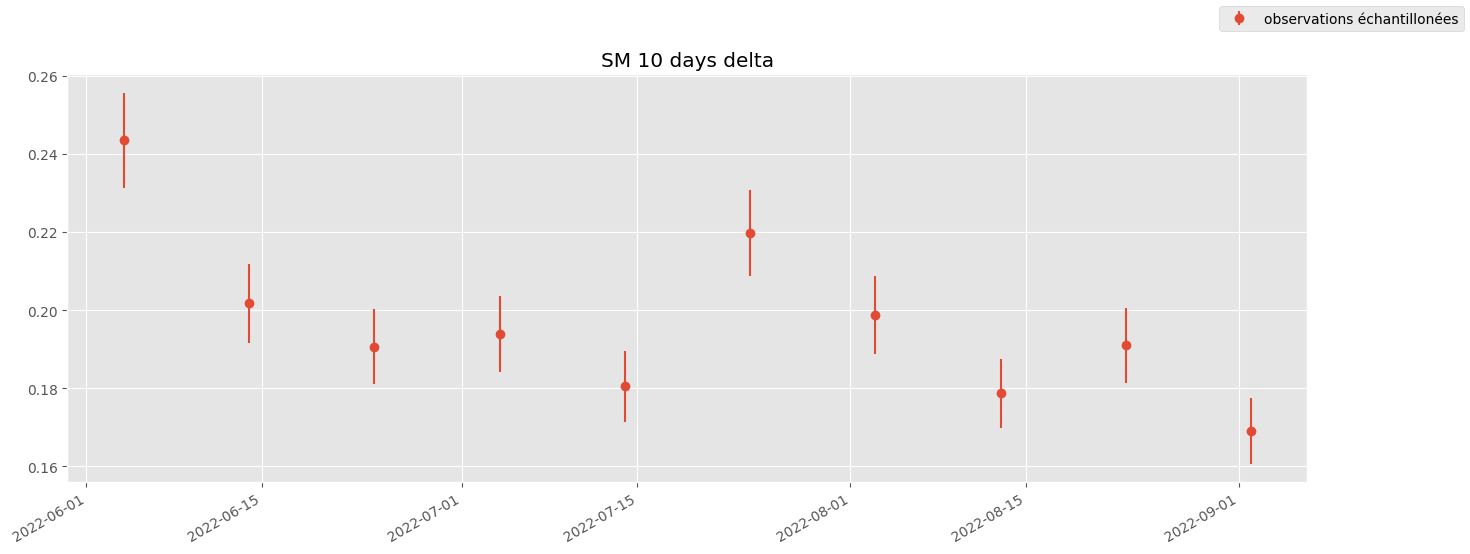

In [7]:
NB_DAYS_DELTA = 10
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]


## 4 - PF

On peut maintenant utiliser le PF. Commençons par spécifier les paramètres sur lesquels nous avons un doute.


=====[Assimilate] Currently on observation 1/10 with 100 particles
Date 2022-06-04 00:00:00, values:{'SM': (0.24350000000000002, 0.012175000000000002)}
[Assimilate] Updated weights. Current SM estimate:  (0.3952107983853378, 0.0010233636875925049)

=====[Assimilate] Currently on observation 2/10 with 100 particles
Date 2022-06-14 00:00:00, values:{'SM': (0.2018, 0.010090000000000002)}
[Assimilate] Updated weights. Current SM estimate:  (0.3949388748699302, 0.0010582691223979671)

=====[Assimilate] Currently on observation 3/10 with 100 particles
Date 2022-06-24 00:00:00, values:{'SM': (0.1907, 0.009535000000000002)}
[Assimilate] Updated weights. Current SM estimate:  (0.3949920409269493, 0.0009438472972843602)

=====[Assimilate] Currently on observation 4/10 with 100 particles
Date 2022-07-04 00:00:00, values:{'SM': (0.19399999999999998, 0.0097)}
[Assimilate] Updated weights. Current SM estimate:  (0.39428382294516084, 0.0011387094750059793)

=====[Assimilate] Currently on observation

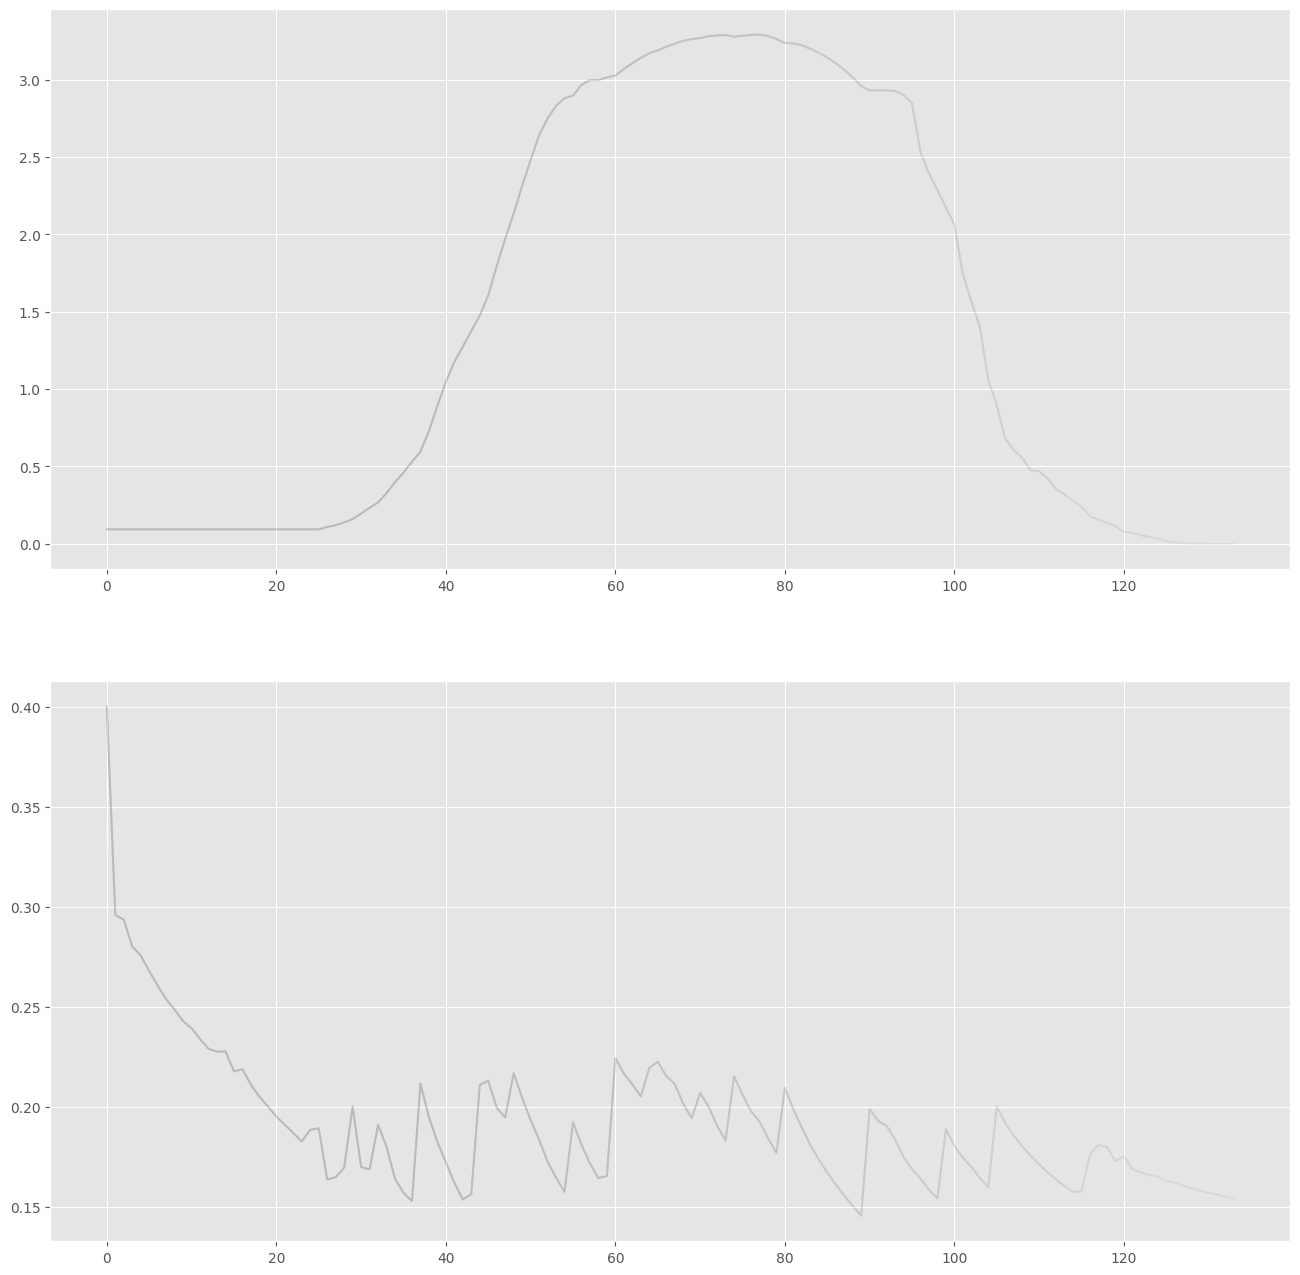

In [8]:

# Appelons maintenant le filtre particulaire
N   = 100
pf  = PfWoFoSt(ensemble_size=N,
              override_parameters=("TDWI","WAV","SPAN","SMFCF"),
              override_ranges=(range1,range2,range3,range4),
              parameters=parameters, weather=weatherd, agromanagement=agrod)
start_date = pf.get_current_date()
df_enkf_NODA = pf.getResultsNoDA()
pf.get_particles_last_value()
pf.batchAssimilate(observations_for_DA)

Comparons avec les données observées :

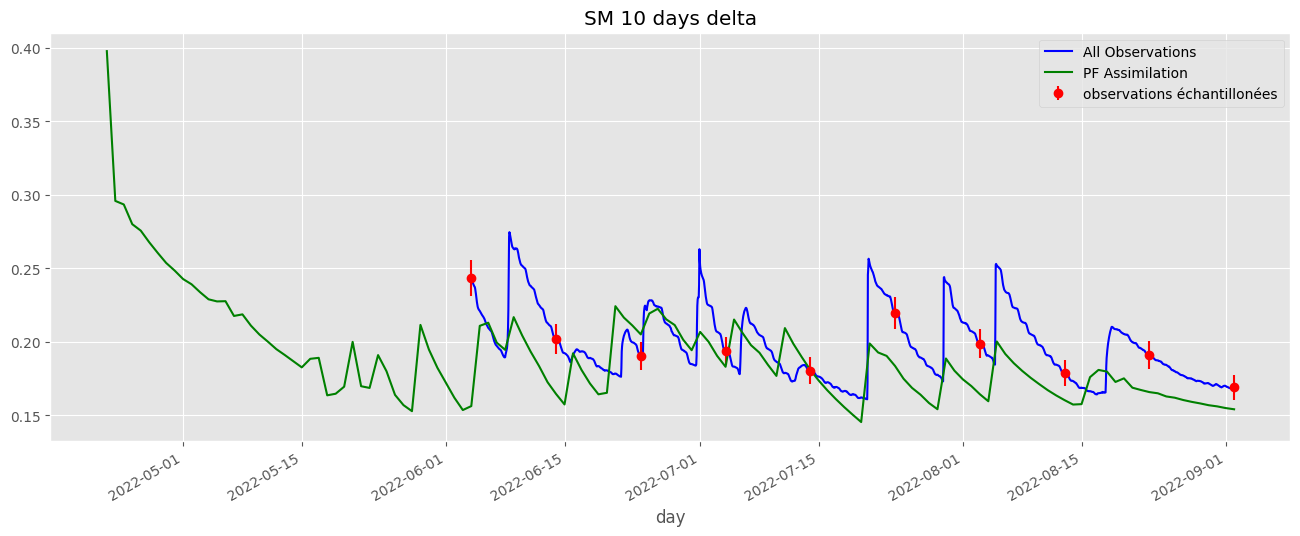

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)

# courbe avec toutes les observations (la réalité)
axes.plot(df_obs['Date/heure'], df_obs["SM"], label="All Observations", color='b')
# courbe avec les observations échantillonées
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées', color='RED')
# courbe avec WOFOST sans aucune correction
# df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA", color="red")

# courbe avec les résultats du PF
results = pf.get_df()
results.plot(y='SM',ax=axes,label='PF Assimilation',color='green')

axes.set_title("SM "+ str(NB_DAYS_DELTA) +" days delta")
axes.legend()
fig.autofmt_xdate()


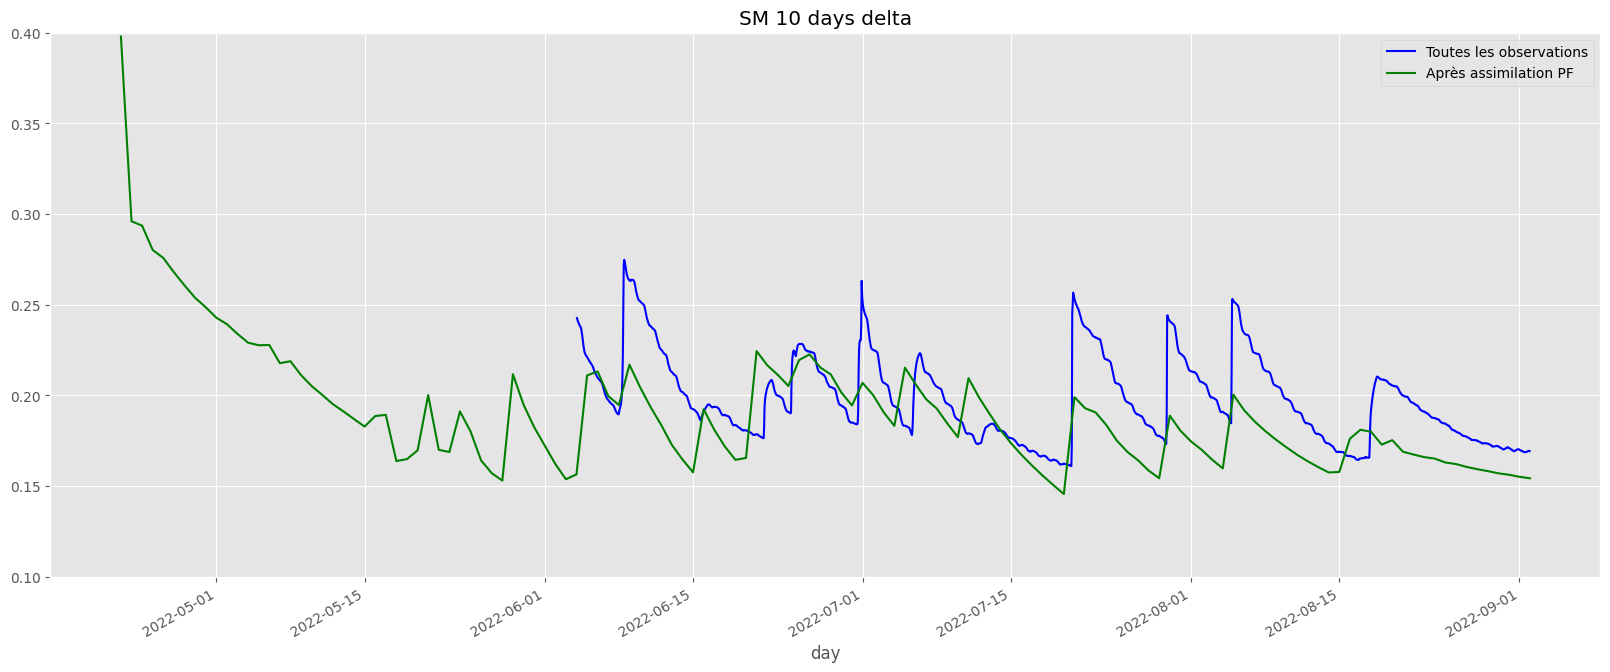

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

axes.plot(df_obs['Date/heure'], df_obs["SM"], label="Toutes les observations", color='b')


results['SM'].plot(ax=axes, label="Après assimilation PF", color='g')


axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
axes.set_ylim([0.1, 0.4])

axes.legend()

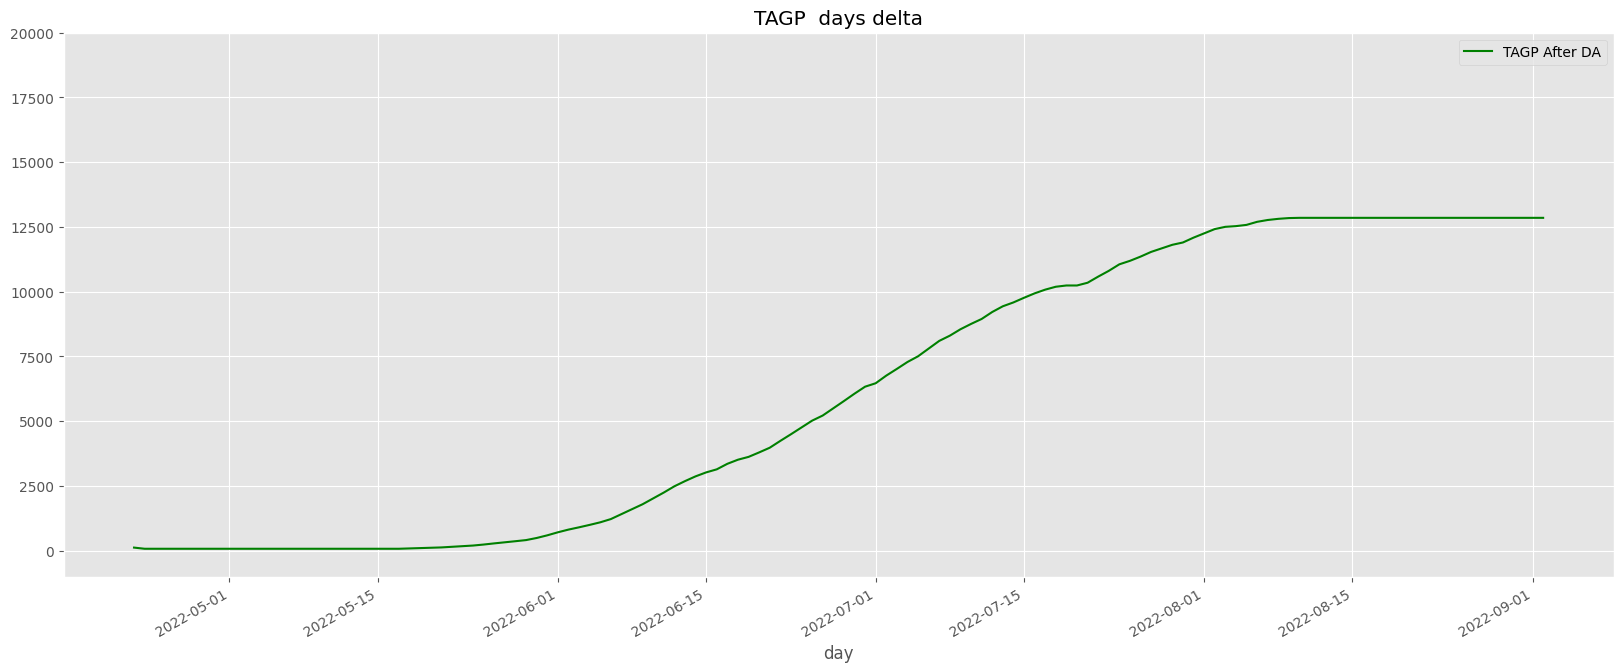

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)
results['TAGP'].plot(ax=axes, label="TAGP After DA", color='g')

#axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='gray')
axes.set_title("TAGP "+str( )+" days delta")
axes.set_ylim([-1000, 20000])
fig.autofmt_xdate()

axes.legend()

Nous allons évaluer le RMSE des résultats assimilé.

In [12]:
type(dates_of_observation[0])

pandas._libs.tslibs.timestamps.Timestamp

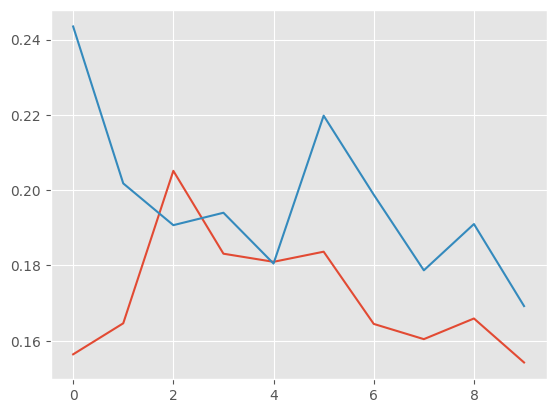

In [13]:
SM_obs = df_obs['SM'].to_numpy()
SM_DA = []

SM_obs = pd.DataFrame({'date':df_obs['Date/heure'], 'SM':df_obs["SM"]})
SM_obs['SM'][SM_obs['date'].isin(dates_of_observation)]

for element in results.index:
    if element in dates_of_observation:
            SM_DA.append(results.loc[element]['SM'])

plt.plot(SM_DA)

plt.plot([element[1]['SM'][0] for element in observations_for_DA])

#df_enkf_NODA['SM'].plot(ax=axes, label="Before DA", color='r')
# results['SM'].plot(ax=axes, label="Après assimilation PF", color='g')


In [14]:
df_obs_under = df_obs[df_obs['Date/heure'].dt.hour == 0][['Date/heure','SM']]
minDay = max(df_obs_under['Date/heure'].min(),results.index.min())
maxDay = min(df_obs_under['Date/heure'].max(),results.index.max())

RSME en pourcentage pour un pas de 10 avec PF : 0.13476319717515434
RSME témoin sans apprentissage : 0.14991962095173939


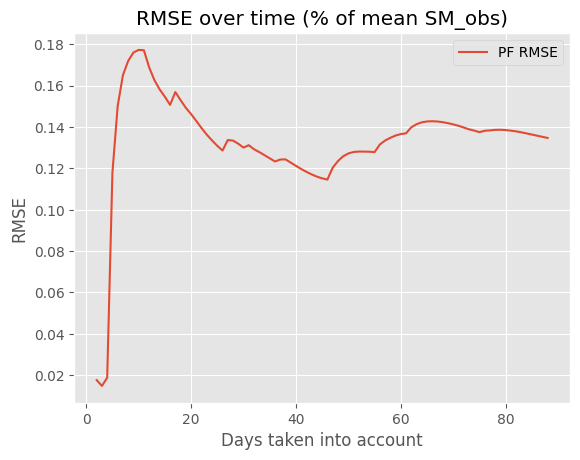

In [15]:
SM_DA  = results.loc[(results.index >= minDay) & (results.index <= maxDay)]['SM'].to_numpy()
SM_obs = df_obs_under.loc[(df_obs_under['Date/heure'] >= str(minDay)) & (df_obs_under['Date/heure'] <= str(maxDay))]['SM'].to_numpy()
SM_noDA= df_wofost_noDA.loc[(df_wofost_noDA.index >= minDay) & (df_wofost_noDA.index <= maxDay)]['SM'].to_numpy()
rsme = {i:np.sqrt(np.mean((SM_obs[1:i]-SM_DA[1:i])**2)) for i in range(len(SM_DA))}
print("RSME en pourcentage pour un pas de {} avec PF : {}".format(NB_DAYS_DELTA, rsme[len(SM_DA)-1]/np.mean(SM_obs)))
print("RSME témoin sans apprentissage : {}".format(np.sqrt(np.mean((SM_obs-SM_noDA)**2))/np.mean(SM_obs)))
plt.plot(list(rsme.keys()),list(rsme.values())/np.mean(SM_obs), label="PF RMSE")
plt.title("RMSE over time (% of mean SM_obs)")
plt.xlabel("Days taken into account")
plt.ylabel("RMSE")
plt.legend()

On peut tirer plusieurs conclusion de ce dernier graphique. Le RMSE est initalement très grand: le PF n'est pas très efficace. Après plusieurs itérations, il se stagne vers 0.035 d'écart, ce qui correspond à 17,5% d'écarts sur la période.
<style>
    table {
        width: 100%;
    }
</style>
| Pas des jours | Erreur RMSE (%) |
|---------------|------- |
|1|10.7|
| 2             | 11,6  |
| 4             | 10,5   |
| 8             | 10,6  |
| 10            | 16,6    |
| témoin        | 15    | 
